# Baseline Model
for our baseline model we chose a 1-day last prediction model, which always predicts the value from the last day as the value for the next day.
Normal space is what we ultimately care about, but since the volatility is so low, it is hard to predict on it. For that reason, we use the log space `logn(x)` to normalize the data.

In [134]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error

In [94]:
# load the data from the preprocessed h5 file
path_root = Path().absolute().parent.resolve()
with pd.HDFStore(path_root / "resources/data/data_formatted.h5") as store:
    df = store["df"]
    x_train = store["x_train"]
    y_train = store["y_train"]
    x_val = store["x_val"]
    y_val = store["y_val"]
    x_test = store["x_test"]
    y_test = store["y_test"]

In [95]:
x_train.head()

,hml,lag_rv_day_log_1,lag_rv_day_log_10,lag_rv_day_log_11,lag_rv_day_log_12,lag_rv_day_log_13,lag_rv_day_log_14,lag_rv_day_log_15,lag_rv_day_log_16,lag_rv_day_log_17,...,lag_rv_week_log_9,liquidity_day_log,liquidity_month_log,liquidity_week_log,mktMinusRiskfree,return_sign_day,return_sign_month,return_sign_week,smb,vix_log
DT,,,,,,,,,,,,,,,,,,,,,
2010-03-04,0.29,-9.253527,-8.762848,-7.970345,-8.109983,-8.220418,-8.100960,-8.246101,-7.744577,-7.212612,...,-8.331060,10.310252,10.760061,10.571604,0.15,0,1.0,0.0,0.09,2.929592
2010-03-05,-0.04,-9.057764,-8.591706,-8.762848,-7.970345,-8.109983,-8.220418,-8.100960,-8.246101,-7.744577,...,-8.258314,10.580429,10.760227,10.497638,0.30,1,1.0,0.0,0.07,2.857619
2010-03-08,0.35,-9.311731,-7.856689,-8.591706,-8.762848,-7.970345,-8.109983,-8.220418,-8.100960,-8.246101,...,-8.306274,10.294820,10.751980,10.444478,1.42,0,1.0,0.0,0.39,2.878637
2010-03-09,0.08,-8.644398,-8.349784,-7.856689,-8.591706,-8.762848,-7.970345,-8.109983,-8.220418,-8.100960,...,-8.408563,10.598508,10.727887,10.448592,0.03,1,1.0,1.0,0.10,2.885917
2010-03-10,-0.18,-8.272543,-8.481787,-8.349784,-7.856689,-8.591706,-8.762848,-7.970345,-8.109983,-8.220418,...,-8.396254,11.107075,10.725954,10.578217,0.13,1,1.0,1.0,0.29,2.921547


In [75]:
def pred_1_prev(x):
    """
    predict the value from data of the previous day. Pass either the value itself, or the dataframe row
    :param x: datapoints from the previous day to predict on
    :return: prediction
    """
    if type(x) == pd.Series:
        return x["lag_rv_day_log_1"]
    else:
        return x

In [11]:
# test the function on the first row - the result will be the same as the input rv
print(x_train.iloc[1,]["lag_rv_day_log_1"], pred_1_prev(x_train.iloc[1,]))

-9.057763513869114 -9.057763513869114


Now lets see how well this performs on the datasets -> store results in a df and compare to the actual values.

In [116]:
# store the actual values
preds_df = pd.concat([y_train,y_val,y_test])
# generate the predictions and add them to the dataframe
# since we try to predict on the value of the next day, we just predict 0
preds_df["preds_train"] = x_train.apply(pred_1_prev, axis=1)
preds_df["preds_val"] = x_val.apply(pred_1_prev, axis=1)
preds_df["preds_test"] = x_test.apply(pred_1_prev, axis=1)
preds_df.head(5)

,outcome_rv_log,preds_train,preds_val,preds_test
DT,,,,
2010-03-04,-9.057764,-9.253527,NaN,NaN
2010-03-05,-9.311731,-9.057764,NaN,NaN
2010-03-08,-8.644398,-9.311731,NaN,NaN
2010-03-09,-8.272543,-8.644398,NaN,NaN
2010-03-10,-8.622301,-8.272543,NaN,NaN


<AxesSubplot:xlabel='DT'>

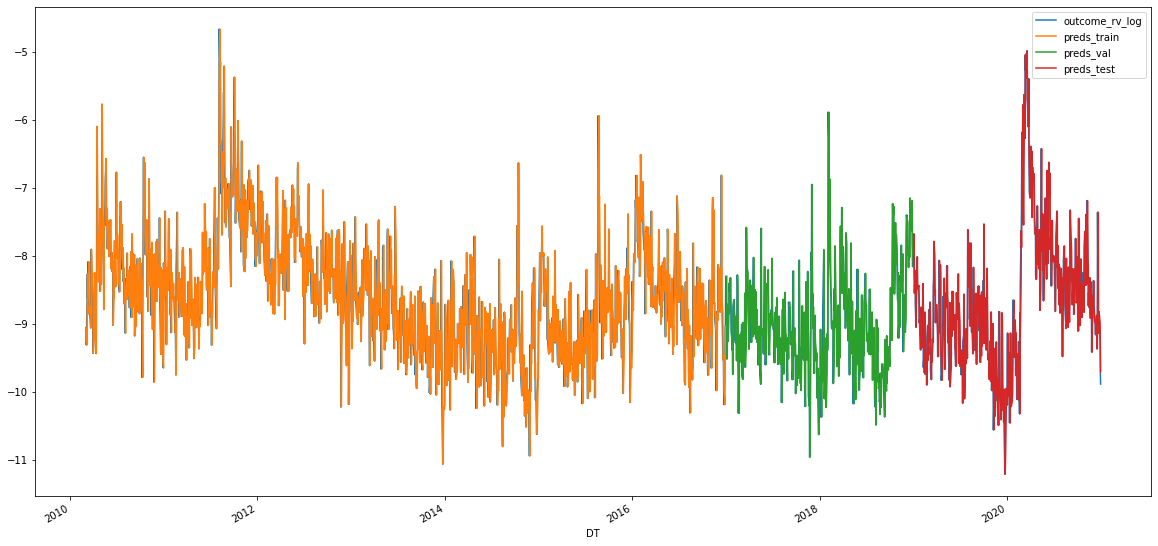

In [140]:
preds_df.plot(figsize=(20,10))

That looks quite alright, but the plot is small and its hard to visually see the error on a right-shift.
Lets calculate the mean squared error to get a comparable error metric.

In [129]:
preds_train = preds_df.dropna(subset=["preds_train"])
mean_squared_error(preds_train["outcome_rv_log"], preds_train["preds_train"])

0.31424885462203345

In [133]:
for x in ["train","val", "test"]:
    preds_tmp = preds_df.dropna(subset=[f"preds_{x}"])
    print(x, mean_squared_error(preds_tmp["outcome_rv_log"], preds_tmp[f"preds_{x}"]))

train 0.31424885462203345
val 0.3047710108342965
test 0.29943104229697015


So our baseline is at ~0.3 MSE in log space. Lets convert the entire dataframe back to normal space to get a baseline for that as well.

As we can see below, our baseline MSE is between 1.2e-7 and 3.19e-8

train 1.2082338162449294e-07
val 3.1957182984777536e-08
test 1.8414494511337697e-07


<AxesSubplot:xlabel='DT'>

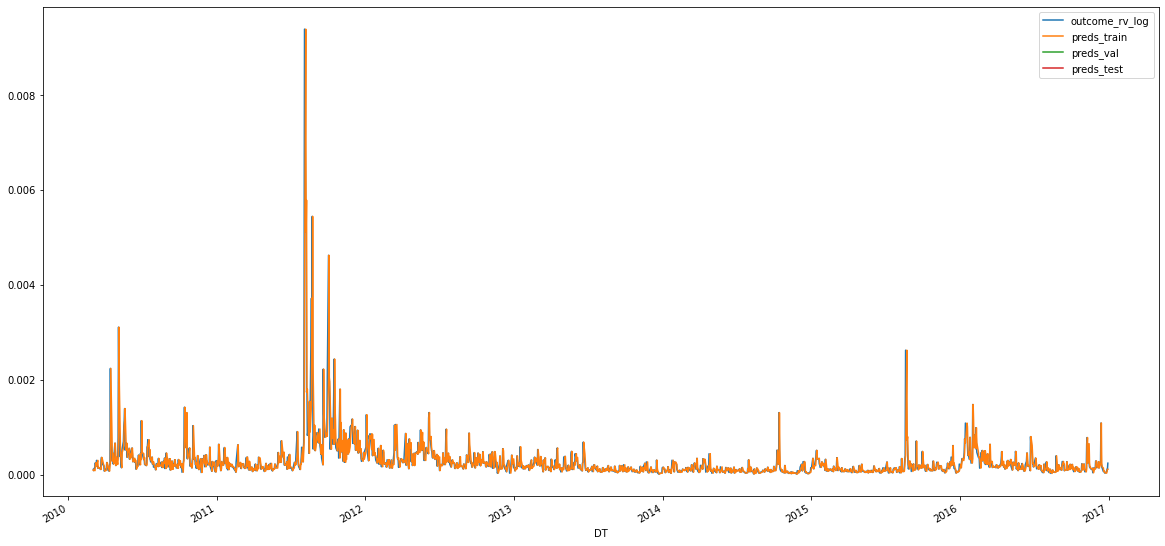

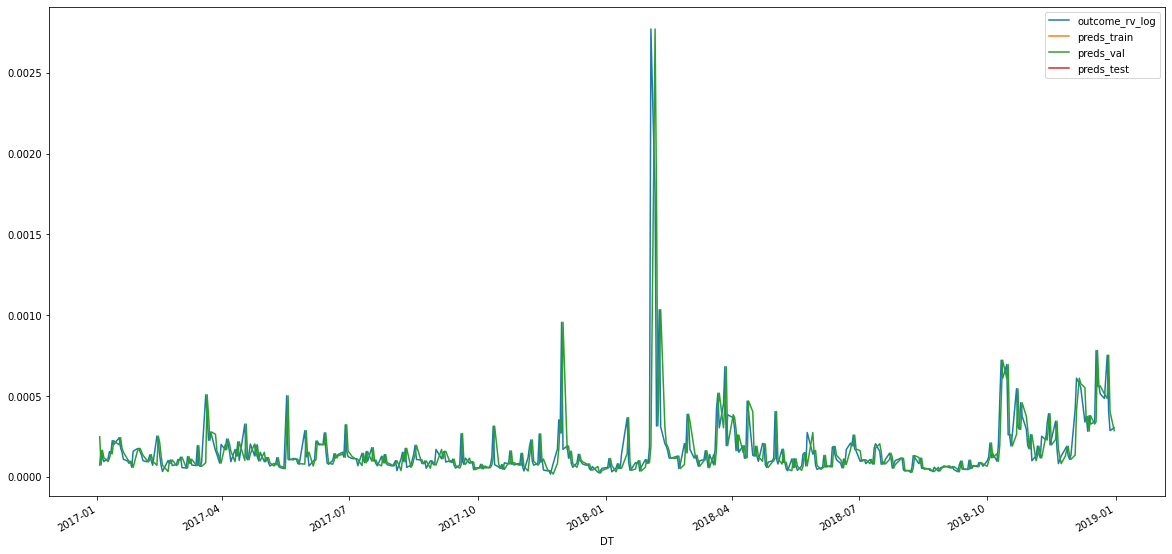

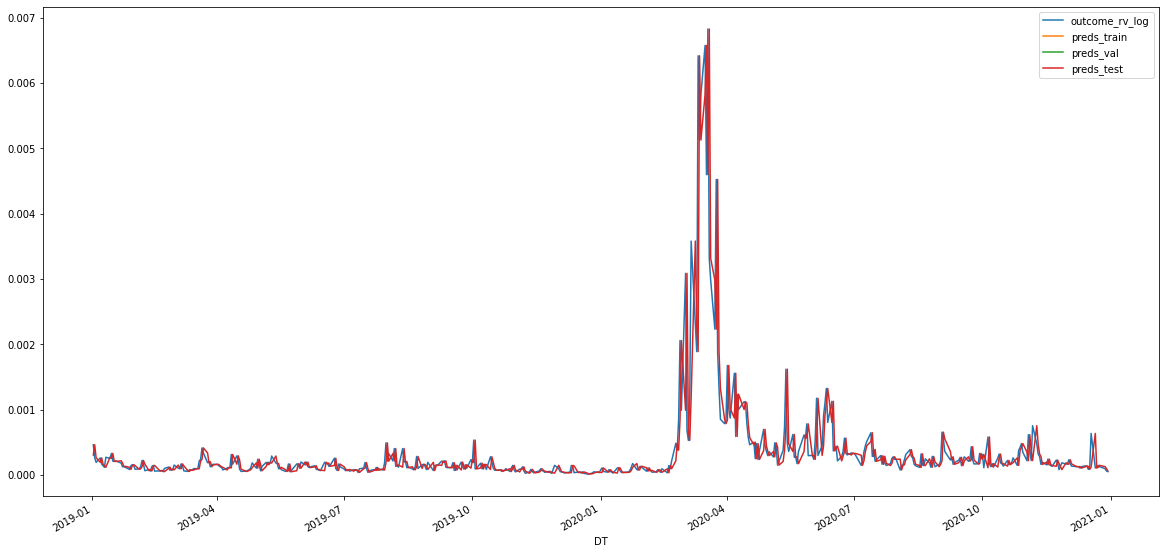

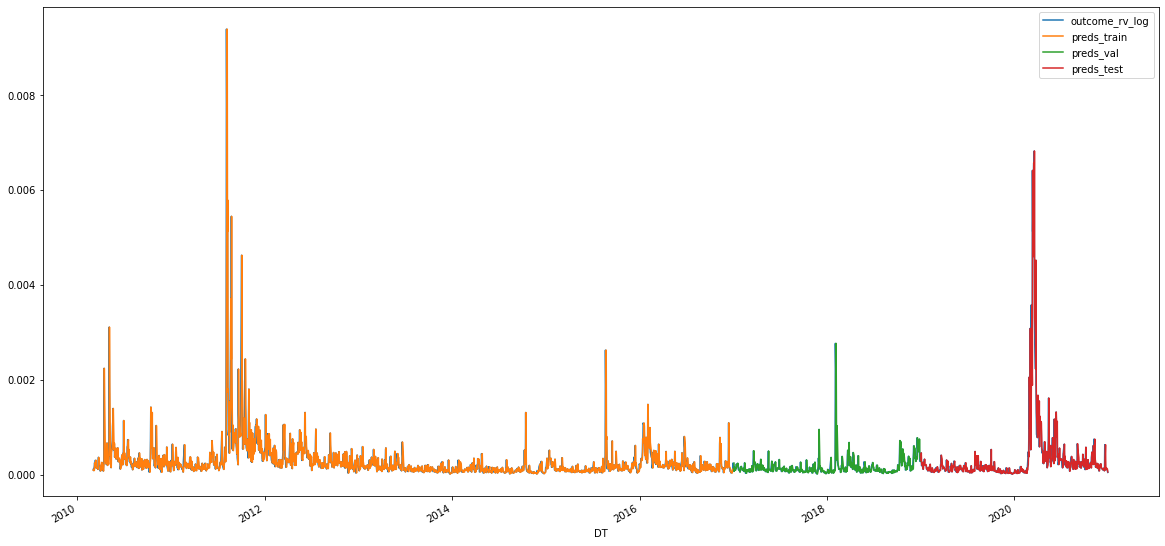

In [142]:
preds_df_norm = np.exp(preds_df)
for x in ["train","val", "test"]:
    preds_tmp = preds_df_norm.dropna(subset=[f"preds_{x}"])
    preds_tmp.plot(figsize=(20,10))
    print(x, mean_squared_error(preds_tmp["outcome_rv_log"], preds_tmp[f"preds_{x}"]))

preds_df_norm.plot(figsize=(20,10))